# Taconic Parkway, DataFest 2022

Hello, we are team Taconic Parkway from Vassar College. Our analysis tries to answer a simple question:

**Do players "get good" or "get tired" of this game?**

While the idea is simple, it took quite some work. We first tracked each player's "game flow" by identifying key events in her playthrough, and calculated how much time each player spent on each mini game in Elm City. We then regressed each player's playing time against time to see a player's change in play time as she progresses through the game. Finally, we used a Monte-Carlo simulation to learn more about player cognitive behaviors on an overall level. 

Here is our analysis on the dataset, in 3 parts:

1. Exploratory Analysis
2. Statistical Model
3. Conclusion

We hope you enjoy it!

## 1. Exploratory Analysis

In [1238]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [542]:
warnings.filterwarnings('ignore')

In [543]:
sns.set_theme()

Let's first take a look at the target variable, drug resistance, in `S5_scores_cleaned.csv`


In [544]:
df_resist = pd.read_csv("Data/S5_scores_cleaned.csv", dtype={'player_id':str}).dropna()

Note: *A higher mean score indicates that the student has lower efficacy in resisting drugs.*

We can invert `S5_mean` to get a resistance score. A higher resistance score means higher efficacy in resisting drugs. A bit more intuitive.

In [545]:
df_resist['resistance'] = 1 / df_resist['S5_mean']

Some questions we can ask:
- How many weeks does it take for players to complete this game?
- How do the players' drug resistance change over time?

How many weeks does it take for players to complete this game?

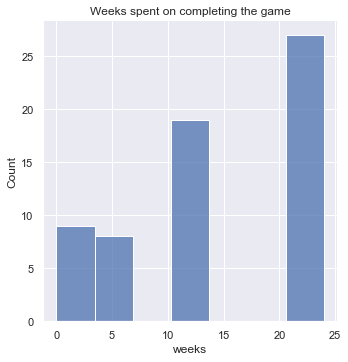

In [547]:
sns.displot(data=df_resist.groupby('player_id').max()['weeks'])
plt.title("Weeks spent on completing the game");

We can see there are 3 groups of players:

- 0-10 weeks
- 10-15 weeks
- 20-25 weeks

How do players' drug resistance change over time for each group?

In [548]:
# 0-5 weeks
player_list_0_5 = df_resist.groupby('player_id').max().query("weeks < 10").index
# 10-15 weeks
player_list_10_15 = df_resist.groupby('player_id').max().query("10 <= weeks < 15").index
# 20-25 weeks
player_list_20_25 = df_resist.groupby('player_id').max().query("20 <= weeks <= 25").index

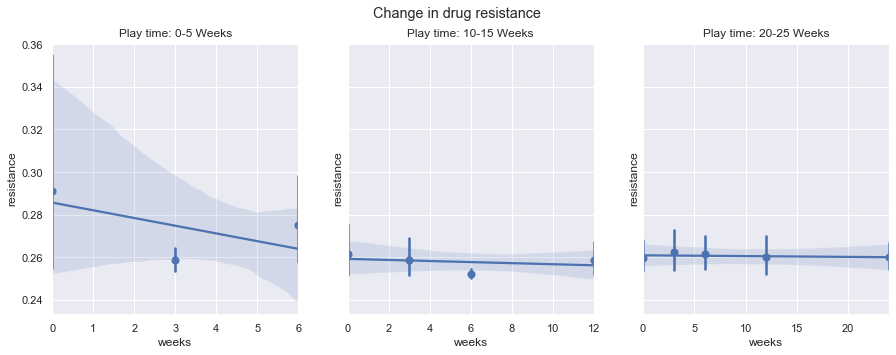

In [1272]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

fig.suptitle('Change in drug resistance')
axes[0].set_title('Play time: 0-5 Weeks')
axes[1].set_title('Play time: 10-15 Weeks')
axes[2].set_title('Play time: 20-25 Weeks')

sns.regplot(ax=axes[0], x='weeks', y='resistance', data=df_resist.where(df_resist['player_id'].isin(player_list_0_5)), x_estimator=np.mean)
sns.regplot(ax=axes[1], x='weeks', y='resistance', data=df_resist.where(df_resist['player_id'].isin(player_list_10_15)), x_estimator=np.mean)
sns.regplot(ax=axes[2], x='weeks', y='resistance', data=df_resist.where(df_resist['player_id'].isin(player_list_20_25)), x_estimator=np.mean);

Turns out `drug_resistance` is not an ideal target variable because the variation is too small. The play time, however, does have plenty of variation we can work with. It's worth diving deeper into player play times.

Moving on to the main dataset, `logs.csv`

In [550]:
df_log = pd.read_csv("Data/logs.csv", low_memory=False)

This dataset is large, so let's focus on just one player first.

In [551]:
player_a = df_log['player_id'][0]
df_player_a = df_log.query(f"player_id == {player_a}")

This game is divided into 12 scenes ("stacks"). Each with a different theme. See `Spreadsheets\ChallengeStacksData.xlsx` for details on each stack.

In [552]:
# keys are stack ids, values are stack themes
stacks = {
    0: "Cheaters",
    1: "Poolside",
    2: "Kissing",
    3: "Pills",
    4: "Misbehavin'",
    5: "New Year's",
    6: "Serious",
    7: "Racing",
    8: "Scare",
    9: "Prom",
    10: "Confide",
    11: "First Job",
    12: "Tutorial"
}

How long does this player spend on each stack? We can write a function for this:

In [553]:
def stack_play_time(player_id):
    '''
    calculates the amount of time a player spends on each stack
    '''
    df_player = df_log.query(f"player_id == {player_id}")
    play_history = df_player.dropna(subset=['stack_id'])[['stack_id', 'event_time_dbl']].groupby('stack_id').max()
    # need to sort by event_time_dbl because players don't necessarily go through stacks in numerical order
    play_history.sort_values(by='event_time_dbl', inplace=True)
    play_times = play_history.diff()
    play_times.rename(columns={'event_time_dbl': 'play_time'}, inplace=True)
    # we don't care about the tutorial
    play_times.drop(index=12, inplace=True)
    play_times.sort_index(inplace=True)
    play_times['description'] = [stacks[x] for x in play_times.index]
    play_times['player_id'] = player_id
    play_times = play_times[['player_id', 'play_time', 'description']]
    play_times.reset_index(inplace=True)
    play_times['stack_id'] = play_times['stack_id'].astype(int)
    return play_times

In [554]:
stack_play_time(player_a)

,stack_id,player_id,play_time,description
0,0,6427001,3835.0,Cheaters
1,1,6427001,1588.0,Poolside
2,2,6427001,2402.0,Kissing
3,3,6427001,1388.0,Pills
4,4,6427001,1867.0,Misbehavin'
5,5,6427001,3045.0,New Year's
6,6,6427001,2972.0,Serious
7,7,6427001,1925.0,Racing
8,8,6427001,2809.0,Scare
9,9,6427001,1025.0,Prom


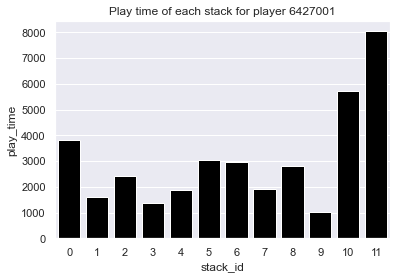

In [1273]:
sns.barplot(x='stack_id', y='play_time', data=stack_play_time(player_a), color='black')
plt.title(f"Play time of each stack for player {player_a}");

Now, let's take a look at this metric on an aggregate level.

In [556]:
df_play_time = pd.concat([stack_play_time(player) for player in df_log['player_id'].unique()])

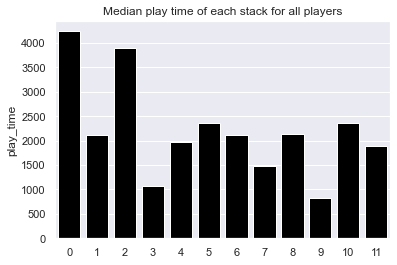

In [1274]:
sns.barplot(x=np.arange(12), y='play_time', data=df_play_time.groupby('stack_id').median(), color='black')
plt.title("Median play time of each stack for all players");

As expected, we are seeing more variations in play time. However, there is another problem. Players jump in between stacks and there are only 12 stacks. This makes regressing against time very difficult.

A better option might be to look at mini games instead of stacks. Compared to stacks, mini games are larger in number (40 vs 12), more independent from one another, and have less "jumping in-between"s. Looking at mini games will give us a more consistent estimation of how a player's play time changes as she progresses through the game.

## 2. Statistical Model

### Feature Engineering
To analyze mini game play times, it is vital for us to know how much each players spent on each mini game and in what order.

In [1225]:
def mini_play_time(player_id):
    # initialize return dataframe
    rtn_idx = []
    for game_type in ['kn', 'pr', 'pe', 're']:
        for level in range(10):
            rtn_idx.append(game_type + f'{level}')
    df_rtn = pd.DataFrame(
        columns=['player_id', 'game_type', 'game_level', 'play_time', 'last_interaction'], 
        index=rtn_idx,
        data={
            'player_id':player_id, 
            'game_type':['knowledge']*10 + ['priority']*10 + ['people']*10 + ['refusal']*10,
            'game_level':list(range(10))*4,
            'play_time':[0]*40,
            'completed_on':[0]*40
            }
        )
    # initialize event log dataframe
    df_sessions = pd.DataFrame(columns=['session_id', 'status', 'event_id', 'row_id', 'time', 'game'])

    # only keep data about this player
    df_player = df_log.query(f"player_id == {player_id}")
    player_events = df_player['event_id']

    # an event 1003 followed by event 1004 indicates game start
    event_1003 = player_events[player_events == 1003]
    session_starts = []
    for idx_1003 in event_1003.index:
        if df_player.at[idx_1003+1, 'event_id'] == 1004:
            session_starts.append(idx_1003)
    
    for i in range(len(session_starts)):
        
        curr_idx = session_starts[i] # this is the index of event 1003
        start_time = df_player.at[curr_idx, 'event_time_dbl']
        # get minigame_id in the 1003 row (0=Knowledge, 1=Priority, 2=People, 3=Refusal)
        minigame_id = df_player.at[curr_idx, 'minigame_id']
        curr_type = ''
        if minigame_id == 0:
            curr_type = 'kn'
        elif minigame_id == 1:
            curr_type = 'pr'
        elif minigame_id == 2:
            curr_type = 'pe'
        elif minigame_id == 3:
            curr_type = 're'
        # get minigame_level in the 1004 row
        curr_level = int(df_player.at[curr_idx+1, 'minigame_level'])
        game = curr_type + str(curr_level)

        # log this into the session dataframe
        df_sessions = pd.concat([
            df_sessions,
            pd.DataFrame(
                data={'session_id':i, 
                'status':'enter',
                'event_id':1003,
                'row_id':df_player.at[curr_idx, 'row_id'],
                'time':start_time,
                'game':game},
                index=[0])], 
            ignore_index=True)

        # window to look for a session end
        if i == len(session_starts)-1:
            events_window = player_events.loc[curr_idx:]
        else:
            events_window = player_events.loc[curr_idx:session_starts[i+1]]
        
        # print(i, session_starts[i], session_starts[i+1])
        # print(player_events[session_starts[i] : session_starts[i+1]])
        # print(events_window)

        # print(f"{events_window.index.values[0]} - {events_window.index.values[-1]}")

        # events (103/1002/1001) end the session
        session_ends = [103, 1002, 1001]
        for e_idx in events_window.index:
            if  events_window[e_idx] in session_ends:

                # print(e_idx, df_player.at[e_idx, 'row_id'], events_window[e_idx])

                # log this into the session dataframe
                df_sessions = pd.concat([
                    df_sessions,
                    pd.DataFrame(
                        data={'session_id':i, 
                        'status':'exit',
                        'event_id':events_window[e_idx],
                        'row_id':df_player.at[e_idx, 'row_id'],
                        'time':df_player.at[e_idx, 'event_time_dbl'],
                        'game':game},
                        index=[0])],
                    ignore_index=True)

                # calculate session duration
                end_time = df_player.at[e_idx, 'event_time_dbl']
                duration = end_time - start_time
                # if the player stayed for between 60 seconds and a 24 hours, update this
                # why 24 hours? because sometimes players quit mid-session and resume days later
                if 60 <= duration <= 24*3600:
                    # variable game is an index, e.g. kn0 for Knowledge Level 0
                    df_rtn.at[game, 'play_time'] += duration
                    df_rtn.at[game, 'last_interaction'] = end_time
                break
    
    # sort return dataframe and drop games that are never played
    df_rtn = df_rtn[df_rtn['play_time'] != 0]
    df_rtn.sort_values(by=['last_interaction'], inplace=True)
    df_rtn.reset_index(drop=True, inplace=True)
            
    return df_rtn, df_sessions


Now we can get the playing history and play time for each player.

In [1223]:
mini_play_time(player_a)[1].head(10)

,session_id,status,event_id,row_id,time,game
0,0,enter,1003,208,998,pe0
1,0,exit,1001,433,1520,pe0
2,1,enter,1003,470,1602,pr0
3,1,exit,1001,747,2307,pr0
4,2,enter,1003,1038,2901,pe0
5,2,exit,1002,1247,3153,pe0
6,3,enter,1003,1285,3263,kn0
7,3,exit,1001,1347,3547,kn0
8,4,enter,1003,1352,3561,kn0
9,4,exit,103,1422,3738,kn0


In [1224]:
mini_play_time(player_a)[0].head(10)

,player_id,game_type,game_level,play_time,last_interaction
0,6427001,priority,0,705,2307
1,6427001,people,0,895,3948
2,6427001,knowledge,0,1127,4667
3,6427001,priority,1,99,6561
4,6427001,refusal,4,162,7696
5,6427001,refusal,0,499,9218
6,6427001,refusal,3,282,9682
7,6427001,refusal,1,496,10057
8,6427001,people,2,289,11490
9,6427001,priority,2,169,11706


Run this function on all players:

In [1186]:
irregular_players = []
player_histories = []

for p in df_log['player_id'].unique():
    try:
        player_histories.append(mini_play_time(p)[0])
    except:
        irregular_players.append(p)

print(f"Number of irregular players: {len(irregular_players)}.")
df_all_players = pd.concat(player_histories, ignore_index=True)

Number of irregular players: 2.


Looks like 2 players have irregular behaviors our algorithm failed to parse. We will not include data from them in our analysis.

In [1220]:
df_all_players.to_csv("all_players.csv", index=False)

Our modelling is done in R. Please [click here](https://github.com/percy-xu/DataFest2022/blob/master/DataFest%202022.Rmd) to see details about the model.

In [1236]:
df_beta1 = pd.read_csv("player_beta1.csv")

In [1240]:
# this is a dataset generated by Monte-Carlo simulation. Each player has a distribution of her beta 1. 
df_beta1.head()

,6427001,6427002,6427004,6427005,6427006,6427007,6427008,6427010,6427011,6427012,...,6608006,6626001,6626002,6626003,6626004,6626005,6626006,6626007,65670031,65670032
0,21.0372,154.3490,16.0661,233.8110,14.4559,188.4220,22.9485,273.46700,6.04442,12.7539,...,10.85750,31.02480,125.8810,-1.51252,8.55424,27.5538,71.8350,31.9650,1.149100,6.65786
1,24.1342,-5.7625,18.5126,127.3000,16.7093,153.6670,24.2131,206.57900,7.68532,14.8939,...,12.84780,16.60470,101.9230,18.29480,10.44070,19.5841,43.9155,35.3333,0.726400,6.27195
2,18.6260,92.3133,14.7178,132.0210,13.1279,173.2430,30.3888,170.42100,5.23951,11.6654,...,9.63621,31.71580,119.0770,97.36010,7.47174,24.6503,69.4865,42.1771,0.982139,4.44455
3,21.9193,105.0120,16.8863,-39.5809,15.2726,-73.9578,42.8427,-8.31042,6.75951,13.5439,...,11.66740,2.38522,38.0793,-210.69900,9.33702,25.8222,-17.5470,57.9313,1.007580,3.00614
4,22.5518,107.7860,17.2205,55.2119,15.5659,76.7848,35.0360,72.00190,6.92307,13.7964,...,11.90880,-29.01760,-58.1635,59.34010,9.55176,30.1515,-97.0506,42.9891,1.431290,2.81907


In [1267]:
ranked_idx = list(df_beta1.mean(axis=0).sort_values().index)

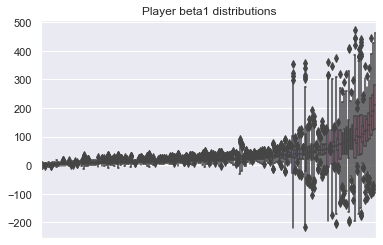

In [1270]:
sns.boxplot(data=df_beta1[ranked_idx]).set(xticklabels=[])
plt.title("Player beta1 distributions");

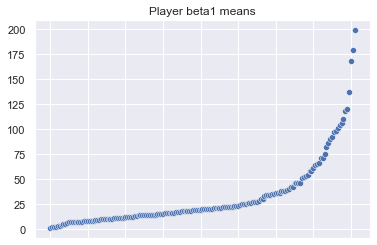

In [1271]:
sns.scatterplot(x=np.arange(len(df_beta1.columns)), y=df_beta1.mean(axis=0).sort_values()).set(xticklabels=[])
plt.title("Player beta1 means");

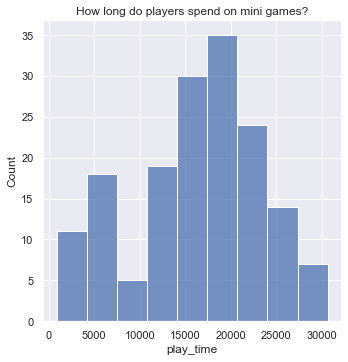

In [1229]:
sns.displot(df_all_players.groupby('player_id').sum()['play_time'])
plt.title("How long do players spend on mini games?");

## 3. Conclusion